# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [1]:
# импорт библиотк
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# чтение файла и создание переменной датафрейма
df = pd.read_csv("https://code.s3.yandex.net/datasets/real_estate_data.csv", sep='\t')
print(len(df))
df.info()

23699
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_near

In [3]:
len(df[df.duplicated()])  # число явных дубликатов

0

In [4]:
# оформление общей таблицы для пропущенных значений
missing_data = pd.DataFrame({'null_rate':df.isna().sum()/len(df)})
missing_data['null_counts'] = df.isna().sum()
missing_data_sorted = missing_data.sort_values('null_rate').query('null_rate > 0')
missing_data_sorted['null_rate'] = missing_data_sorted['null_rate'].map(lambda x: '{:.2%}'.format(x))
print(f'В {len(missing_data_sorted)} показателях отсутствуют данные')
missing_data_sorted

В 14 показателях отсутствуют данные


,null_rate,null_counts
locality_name,0.21%,49
floors_total,0.36%,86
living_area,8.03%,1903
kitchen_area,9.61%,2278
days_exposition,13.42%,3181
ponds_around3000,23.28%,5518
parks_around3000,23.28%,5518
cityCenters_nearest,23.29%,5519
airports_nearest,23.38%,5542
ceiling_height,38.80%,9195


### Вывод
* данные представлены в файле из 23699 строк и 22 показателей
* явные дубликаты отсутствуют
* в 13 показателях имеются пропуски

## Предобработка данных

In [5]:
# В следующих категориях данные отсутствуют
set(missing_data_sorted.index)

{'airports_nearest',
 'balcony',
 'ceiling_height',
 'cityCenters_nearest',
 'days_exposition',
 'floors_total',
 'is_apartment',
 'kitchen_area',
 'living_area',
 'locality_name',
 'parks_around3000',
 'parks_nearest',
 'ponds_around3000',
 'ponds_nearest'}

Сначала преобразуем данные общей площади и этажность в целые числа

In [6]:
df.total_area = df.total_area.astype('int')

Рассмотрим их по отедельности и попытаемся восстановить те из них, которые задействованы в постановленной задаче, некоторые из них оставим без изменения

* ***airports_nearest*** - расстояние до ближайшего аэропорта в метрах (м): 
оставим без изменения
* ***balcony*** - количество балконов: логично предположить, что отсутствие балкона в квартире могло быть не занесено, поэтому пропуски заменим на "0"

In [7]:
print(f'Количество пропусков по балконам до обработки: {df.balcony.isna().sum()}')
df.loc[df['balcony'].isna(), 'balcony'] = 0
print(f'Количество пропусков по балконам после обработки: {df.balcony.isna().sum()}')
df.balcony = df.balcony.astype('int')
print(f'Уникальные значения для кол-ва балконов: {df.balcony.unique()}')
print(f'Тип данных в количестве балконов: {df.balcony.dtype}')
len(df.balcony)

Количество пропусков по балконам до обработки: 11519
Количество пропусков по балконам после обработки: 0
Уникальные значения для кол-ва балконов: [0 2 1 5 4 3]
Тип данных в количестве балконов: int32


23699

* ***ceiling_height*** - высота потолков: в большенстве своем дома построены типовые, поэтому заменим недостающие данные медианным значением

In [8]:
print(f'Количество пропусков в датасете по высоте потолков до обработки: {df.ceiling_height.isna().sum()}')
df.loc[df['ceiling_height'].isna(), 'ceiling_height'] = df.ceiling_height.median()
print(f'Медианное значение для высоты потолков: {df.ceiling_height.median()}')
print(f'Количество пропусков в датасете по высоте потолков после обработки: {df.ceiling_height.isna().sum()}')
len(df.ceiling_height)

Количество пропусков в датасете по высоте потолков до обработки: 9195
Медианное значение для высоты потолков: 2.65
Количество пропусков в датасете по высоте потолков после обработки: 0


23699

* ***cityCenters_nearest*** - расстояние до центра города: оставим без изменения
* ***days_exposition*** - длительность размещения публикации оставим без изменения
* ***floors_total*** - всего этажей в доме: заменим неизвестные значения на "1" и преведем к натуральному виду

In [9]:
print(f'Кол-во незаполенных значений: {df.floors_total.isna().sum()}')
df.floors_total = df.floors_total.fillna(1)
print(f'Кол-во незаполенных значений: {df.floors_total.isna().sum()}')
df.floors_total = df.floors_total.astype('int')

Кол-во незаполенных значений: 86
Кол-во незаполенных значений: 0


* ***is_apartment*** - апартаменты (булев тип): логично предположить, что позиции, не являющиеся апартаментами не заполнялись, поэтому заменим их на значение "False"

In [10]:
df.loc[df['is_apartment'].isna(), 'is_apartment'] = False
print(f'Количество пропусков в датасете по апартаментам: {df.is_apartment.isna().sum()}')
print(f'Тип данных по апартаментам {df.is_apartment.dtype}')
df.is_apartment.unique()

Количество пропусков в датасете по апартаментам: 0
Тип данных по апартаментам object


array([False, True], dtype=object)

In [11]:
# print('Количество студий без указания площади кухни: ', \
#     len(df[(df['studio'] == 1) & df['kitchen_area'].isna()]))
# print(f'Общее число студий: {df.studio.sum()}')

In [12]:
# print('Количество не студий без указания площади кухни до обработки: ', \
#     len(df[(df['studio'] == 0) & df['kitchen_area'].isna()]))
# df.loc[df['studio'] == 0, 'kitchen_area'] = df.kitchen_area.median()  # медиана площади кухни не в студии
# print(f'Медиана площади кухни: {df.kitchen_area.median()}')
# print('Количество студий без указания площади кухни: ', \
#     len(df[(df['studio'] == 1) & df['kitchen_area'].isna()]))
# print('Количество НЕ студий без указания площади кухни после обработки: ', \
#     len(df[(df['studio'] == 0) & df['kitchen_area'].isna()]))

<span style='background:yellow'>***kitchen_area*** - площадь кухни заполним медианным значением в соответствии с разбиением по количеству комнат
</span>

In [11]:
print('Количество не студий без указания площади кухни до обработки: ', \
    len(df[(df['studio'] == 0) & df['kitchen_area'].isna()]))
for unique_rooms in df.rooms.unique():
    median = df.loc[df['rooms'] == unique_rooms, 'kitchen_area'].median()
    print(f'Медиана площади кухни: {median}')
    print(f'для кол-ва комнат: {unique_rooms}')
    print()
    df.loc[(df['kitchen_area'].isna()) & (df['rooms'] == unique_rooms), 'kitchen_area'] = median
print('Количество НЕ студий без указания площади кухни после обработки: ', \
      len(df[(df['studio'] == 0) & df['kitchen_area'].isna()]))

Количество не студий без указания площади кухни до обработки:  2129
Медиана площади кухни: 9.5
для кол-ва комнат: 3

Медиана площади кухни: 9.04
для кол-ва комнат: 1

Медиана площади кухни: 8.8
для кол-ва комнат: 2

Медиана площади кухни: 11.1
для кол-ва комнат: 4

Медиана площади кухни: 15.1
для кол-ва комнат: 5

Медиана площади кухни: 19.5
для кол-ва комнат: 6

Медиана площади кухни: nan
для кол-ва комнат: 0

Медиана площади кухни: 20.0
для кол-ва комнат: 7

Медиана площади кухни: 12.600000000000001
для кол-ва комнат: 11

Медиана площади кухни: 25.0
для кол-ва комнат: 8

Медиана площади кухни: 21.25
для кол-ва комнат: 14

Медиана площади кухни: 19.8
для кол-ва комнат: 10

Медиана площади кухни: 100.0
для кол-ва комнат: 15

Медиана площади кухни: 14.3
для кол-ва комнат: 9

Медиана площади кухни: 27.6
для кол-ва комнат: 19

Медиана площади кухни: 13.0
для кол-ва комнат: 16

Медиана площади кухни: 112.0
для кол-ва комнат: 12

Количество НЕ студий без указания площади кухни после обработ

In [12]:
# print('Количество отсутствующих значений жилой плащади в студиях', \
#       df.loc[df['studio'] == 1, 'living_area'].isnull().sum())
# print('Количество отсутствующих значений жилой плащади не в студиях', \
#       df.loc[df['studio'] == 0, 'living_area'].isnull().sum())

# # Проведем замену отсутствующих значений жилой площади с разбиением по категории "студия: да / нет"
# for unique_studio_value in df.studio.unique():
#      median = df.loc[df['studio'] == unique_studio_value, 'living_area'].median()
#      print(f'Тип студии: {unique_studio_value} \nМедиана: {median}')
#      print()
#      df.loc[(df['living_area'].isna()) & (df['studio'] == unique_studio_value), 'living_area'] = median
    
# print('Количество отсутствующих значений жилой плащади в студиях', \
#       df.loc[df['studio'] == 1, 'living_area'].isnull().sum())
# print('Количество отсутствующих значений жилой плащади не в студиях', \
#       df.loc[df['studio'] == 0, 'living_area'].isnull().sum())

<span style='background:yellow'>***living_area*** - жилая площадь в квадратных метрах (м²), заполним медианным значением в соответствии с разбиением по количеству комнат и для студий
</span>

In [13]:
print('Количество отсутствующих значений жилой плащади в студиях', \
      df.loc[df['studio'] == 1, 'living_area'].isnull().sum())
print('Количество отсутствующих значений жилой плащади НЕ в студиях', \
      df.loc[df['studio'] == 0, 'living_area'].isnull().sum())

# замена пропусков жилой площади в студиях
df.loc[df['studio'] == 1, 'studio'] = df.loc[df['studio'] == 1, 'living_area'].median()
print('Количество отсутствующих значений жилой плащади в студиях', \
      df.loc[df['studio'] == 1, 'living_area'].isnull().sum())

# замена пропусков жилой площади НЕ в студиях
for unique_rooms in df.rooms.unique():
    median = df.loc[df['rooms'] == unique_rooms, 'living_area'].median()
    print(f'Медиана жилой площади: {median}')
    print(f'для кол-ва комнат: {unique_rooms}')
    print()
    df.loc[(df['living_area'].isna()) & (df['rooms'] == unique_rooms), 'living_area'] = median
print('Количество отсутствующих значений жилой плащади НЕ в студиях: ', \
      len(df[(df['studio'] == 0) & df['living_area'].isna()]))

Количество отсутствующих значений жилой плащади в студиях 10
Количество отсутствующих значений жилой плащади НЕ в студиях 1893
Количество отсутствующих значений жилой плащади в студиях 0
Медиана жилой площади: 45.0
для кол-ва комнат: 3

Медиана жилой площади: 17.6
для кол-ва комнат: 1

Медиана жилой площади: 30.5
для кол-ва комнат: 2

Медиана жилой площади: 63.6
для кол-ва комнат: 4

Медиана жилой площади: 91.785
для кол-ва комнат: 5

Медиана жилой площади: 123.9
для кол-ва комнат: 6

Медиана жилой площади: 18.0
для кол-ва комнат: 0

Медиана жилой площади: 145.0
для кол-ва комнат: 7

Медиана жилой площади: 133.9
для кол-ва комнат: 11

Медиана жилой площади: 161.0
для кол-ва комнат: 8

Медиана жилой площади: 195.15
для кол-ва комнат: 14

Медиана жилой площади: 161.4
для кол-ва комнат: 10

Медиана жилой площади: 409.0
для кол-ва комнат: 15

Медиана жилой площади: 179.2
для кол-ва комнат: 9

Медиана жилой площади: 264.5
для кол-ва комнат: 19

Медиана жилой площади: 180.0
для кол-ва комнат

* ***locality_name*** - название населённого пункта: предугадать невозможно, оставим как есть
* ***parks_around3000*** - число парков в радиусе 3 км: заменим на медианное значение

In [14]:
print(f'Количество пропусков по числу парков в радиусе 3 км до обработки: {df.parks_around3000.isna().sum()}')
df.loc[df['parks_around3000'].isna(), 'parks_around3000'] = df.parks_around3000.median()
df.parks_around3000 = df.parks_around3000.astype('int')
print(f'Количество пропусков по числу парков в радиусе 3 км после обработки: {df.parks_around3000.isna().sum()}')
print(f'Тип данных по числу парков в радиусе 3 км {df.parks_around3000.dtype}')

Количество пропусков по числу парков в радиусе 3 км до обработки: 5518
Количество пропусков по числу парков в радиусе 3 км после обработки: 0
Тип данных по числу парков в радиусе 3 км int32


* ***parks_nearest*** - расстояние до ближайшего парка (м): заменим на медианное значение

In [15]:
print(f'Количество пропусков по расстоянию до ближайшего парка (м) до обработки: {df.parks_nearest.isna().sum()}')
df.loc[df['parks_nearest'].isna(), 'parks_nearest'] = df.parks_nearest.median()
df.parks_nearest = df.parks_nearest.astype('int')
print(f'Количество пропусков по расстоянию до ближайшего парка (м) после обработки: {df.parks_nearest.isna().sum()}')
print(f'Тип данных по расстоянию до ближайшего парка (м) {df.parks_nearest.dtype}')

Количество пропусков по расстоянию до ближайшего парка (м) до обработки: 15620
Количество пропусков по расстоянию до ближайшего парка (м) после обработки: 0
Тип данных по расстоянию до ближайшего парка (м) int32


* ***ponds_around3000*** - число водоёмов в радиусе 3 км: заменим на медианное значение

In [16]:
print(f'Количество пропусков по числу водоёмов в радиусе 3 км после обработки: {df.ponds_around3000.isna().sum()}')
df.loc[df['ponds_around3000'].isna(), 'ponds_around3000'] = df.ponds_around3000.median()
df.ponds_around3000 = df.ponds_around3000.astype('int')
print(f'Количество пропусков по числу водоёмов в радиусе 3 км до обработки: {df.ponds_around3000.isna().sum()}')
print(f'Тип данных по числу водоёмов в радиусе 3 км {df.ponds_around3000.dtype}')

Количество пропусков по числу водоёмов в радиусе 3 км после обработки: 5518
Количество пропусков по числу водоёмов в радиусе 3 км до обработки: 0
Тип данных по числу водоёмов в радиусе 3 км int32


* ***ponds_nearest*** - расстояние до ближайшего водоёма (м): заменим на медианное значение

In [17]:
print(f'Количество пропусков по расстоянию до ближайшего водоёма (м) до обработки: {df.ponds_nearest.isna().sum()}')
df.loc[df['ponds_nearest'].isna(), 'ponds_nearest'] = df.ponds_nearest.median()
df.ponds_nearest = df.ponds_nearest.astype('int')
print(f'Количество пропусков по расстоянию ближайшего водоёма (м) после обработки: {df.ponds_nearest.isna().sum()}')
print(f'Тип данных по расстоянию до ближайшего водоёма (м) {df.ponds_nearest.dtype}')

Количество пропусков по расстоянию до ближайшего водоёма (м) до обработки: 14589
Количество пропусков по расстоянию ближайшего водоёма (м) после обработки: 0
Тип данных по расстоянию до ближайшего водоёма (м) int32


Представим результаты стадии предобработки данных в виде таблицы

In [18]:
md_after_filling = pd.DataFrame({'null_rate':df.isna().sum()/len(df)})
md_after_filling['null_counts'] = df.isna().sum()
md_after_filling_sorted = md_after_filling.sort_values('null_rate').query('null_rate > 0')
md_after_filling_sorted['null_rate'] = md_after_filling_sorted['null_rate'].map(lambda x: '{:.2%}'.format(x))
print(f'В {len(md_after_filling_sorted)} показателях данные оставлены неизменными')
md_after_filling_sorted

В 5 показателях данные оставлены неизменными


,null_rate,null_counts
locality_name,0.21%,49
kitchen_area,0.83%,197
days_exposition,13.42%,3181
cityCenters_nearest,23.29%,5519
airports_nearest,23.38%,5542


In [19]:
null_rate_comparison_df = missing_data.merge(md_after_filling, left_index=True, right_index=True) \
    .query('null_rate_x > 0')

display(null_rate_comparison_df)

print('Кол-во полностью заполненных параметров:', \
      len(null_rate_comparison_df.query('null_rate_x != 0 & null_rate_y == 0')))
null_rate_comparison_df.query('null_counts_x != 0 & null_counts_y == 0')

,null_rate_x,null_counts_x,null_rate_y,null_counts_y
ceiling_height,0.387991,9195,0.000000,0
floors_total,0.003629,86,0.000000,0
living_area,0.080299,1903,0.000000,0
is_apartment,0.882906,20924,0.000000,0
kitchen_area,0.096122,2278,0.008313,197
balcony,0.486054,11519,0.000000,0
locality_name,0.002068,49,0.002068,49
airports_nearest,0.233850,5542,0.233850,5542
cityCenters_nearest,0.232879,5519,0.232879,5519
parks_around3000,0.232837,5518,0.000000,0


Кол-во полностью заполненных параметров: 9


,null_rate_x,null_counts_x,null_rate_y,null_counts_y
ceiling_height,0.387991,9195,0.0,0
floors_total,0.003629,86,0.0,0
living_area,0.080299,1903,0.0,0
is_apartment,0.882906,20924,0.0,0
balcony,0.486054,11519,0.0,0
parks_around3000,0.232837,5518,0.0,0
parks_nearest,0.659100,15620,0.0,0
ponds_around3000,0.232837,5518,0.0,0
ponds_nearest,0.615596,14589,0.0,0


### ***Вывод***
Заполнены пропуски в таких показателях, как:
* Количество балконов
* Высота потолков
* Первый этаж
* Статус апартаментов
* Площадь кухни
* Жилая площадь
* Число парков в радиусе 3 км
* Расстояние до ближайшего парка (м)
* Число водоёмов в радиусе 3 км
* Расстояние до ближайшего водоёма (м)

## Расчёты и добавление результатов в таблицу

### Цена квадратного метра

In [20]:
df['a_squere_meter_price'] = df['last_price'] / df['total_area']
df['a_squere_meter_price'].astype('int').head()

0    120370
1     83750
2     92785
3    408176
4    100000
Name: a_squere_meter_price, dtype: int32

### День недели, месяц и год публикации объявления
#### День недели публикации объявления

In [21]:
df.first_day_exposition.head(1)    # проверка вида хранения даты

0    2019-03-07T00:00:00
Name: first_day_exposition, dtype: object

In [22]:
df['date'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M') # перевод в унив. вид
df.date.head(3)

0   2019-03-07
1   2018-12-04
2   2015-08-20
Name: date, dtype: datetime64[ns]

In [23]:
df['a_day'] = df['date'].dt.weekday   # добавление столбца дня недели
sorted(df.a_day.unique())

[0, 1, 2, 3, 4, 5, 6]

#### Месяц  публикации объявления

In [24]:
df['a_month'] = df['date'].dt.month   # добавление столбца месяца
sorted(df.a_month.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [25]:
df['a_year'] = df['date'].dt.year   # добавление столбца месяца
sorted(df.a_year.unique())

[2014, 2015, 2016, 2017, 2018, 2019]

### Этаж квартиры (*варианты — первый, последний, другой*)

In [26]:
df.floors_total.isna().sum()            # кол-во пропусков

0

In [27]:
df.floor.isna().sum()            # кол-во пропусков

0

In [28]:
print(sorted(df.floor.unique()))  # проверка имеющихся значений этажей

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [29]:
print(sorted(df.floors_total.unique()))  # проверка имеющейся этажности

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 34, 35, 36, 37, 52, 60]


In [30]:
row_values = [df.floors_total, df.floor]
row_columns = ['floors_total', 'floor']    
row = pd.Series(data=row_values, index=row_columns)

def floor_cat(row):             # определение ф-ции для внесения категорий разбиения этажа
    
    val_floors_total = row['floors_total']
    val_floor = row['floor']
    
    if val_floors_total == 1:
        return 'first'
    if val_floors_total == 2:
        if val_floor == 1:
            return 'first'
        else: return 'last'
    else:
        if val_floor == 1:
            return 'first'
        if val_floor == val_floors_total:
            return 'last'
        else: return 'other'

df['a_floor_cat'] = df.apply(floor_cat, axis=1 )   # добавление столбца категории этажа
df['a_floor_cat'].value_counts()

other    17363
last      3336
first     3000
Name: a_floor_cat, dtype: int64

### Соотношение жилой и общей площади, а также отношение площади кухни к общей
#### Соотношение жилой и общей площади

In [31]:
df['a_living_to_total_area'] = df.living_area / df.total_area  # добавление столобца
df.a_living_to_total_area.describe()

count    23699.000000
mean         0.566423
std          0.111237
min          0.021583
25%          0.493147
50%          0.568519
75%          0.641394
max          1.514286
Name: a_living_to_total_area, dtype: float64

#### Соотношение площади кухни к общей площади

In [32]:
df['a_kitchen_to_total_area'] = df.kitchen_area  / df.total_area    # добавление столобца
df.a_kitchen_to_total_area.describe()

count    23502.000000
mean         0.189195
std          0.074742
min          0.018300
25%          0.134125
50%          0.173660
75%          0.234043
max          0.787879
Name: a_kitchen_to_total_area, dtype: float64

#### ***Вывод***

Добавлены значения:
* Цена квадратного метра
* День недели, месяц и год публикации объявления

Проведена группировка этажей квартир по этажности: первый этаж, последний этаж, другой
* Проведена группировка этажей квартир по этажности: первый этаж, последний этаж, другой
* 3000 квартир на первом этаже
* 3336 квартир на последнем этаже
* 17363 квартиры сгруппированы по этажности в категорию «другие»


* Соотношение жилой и общей площади составляет в медиане порядка 50%
* Соотношение площади кухни к общей площади составляет в медиане порядка 18%


## Исследовательский анализ данных

Рассмотрим следующие параметры: площадь, цена, число комнат, высота потолков. Построим гистограммы для каждого параметра.

### Площадь

In [33]:
df.total_area.describe()

count    23699.000000
mean        60.120511
std         35.665822
min         12.000000
25%         40.000000
50%         52.000000
75%         69.000000
max        900.000000
Name: total_area, dtype: float64

* Минимальное значение составляет 12кв.м
* Среднее - 60кв.м
* Медиана - 52кв.м
* Максимальное - 900кв.м (скорее всего ошибка ввода)

<AxesSubplot:>

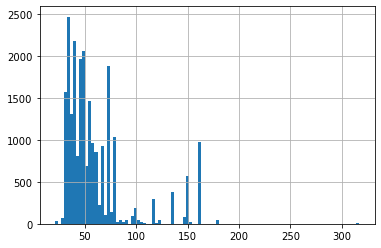

In [34]:
df.query('total_area').total_area.hist(bins=100)   # общая гистограмма

Так как возникают отчетливые отдельные всплески данных, начиная приблизительно от 120кв.м., а студии начинаются от 12кв.м, то можно предположить, что данные всплески являются результатом неправильного ввода. Рассмотрим их подробнее

<AxesSubplot:>

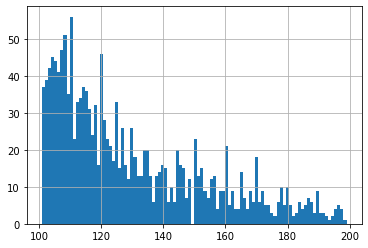

In [35]:
df.query('100 < total_area < 200').total_area.hist(bins=100) # гистограмма для площади от 100кв.м до 200кв.м

Явно выделенных групп, которые соответствуют ошибкам ввода не выявлено

### Цена

In [36]:
#Для наглядности переведем цену в тысячи
df.last_price = df.last_price / 1000
df.last_price.describe()

count     23699.000000
mean       6541.548772
std       10887.013268
min          12.190000
25%        3400.000000
50%        4650.000000
75%        6800.000000
max      763000.000000
Name: last_price, dtype: float64

* Минимальное значение составляет 12.000р (скорее всего, ошибка)
* Среднее - 6,500,000р
* Медиана - 4,650,000р
* Максимальное - 763,000,000р

<AxesSubplot:>

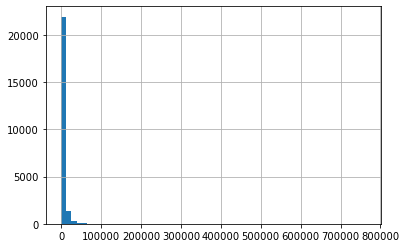

In [37]:
df.last_price.hist(bins=60)    # общая гистограмма

<AxesSubplot:>

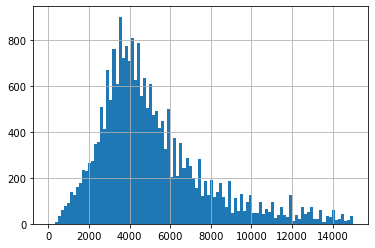

In [38]:
# рассмотрим цену до 15,000,000р
df.query('0 < last_price < 15000').last_price.hist(bins=100)  # гистограмма для цены от 0р.м до 15 млн.р

<AxesSubplot:>

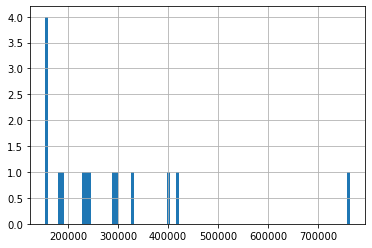

In [39]:
# рассмотрим цену вплоть до максимальной
df.query('150000 < last_price < 764000').last_price.hist(bins=100)  # гистограмма для цены от 15 млн.р до 764млн.р.

Имеются группы и отдельные продажы с высоким показателем цены, что естественно для предложений дорогих объектов жилой недвижимости и аппартаментов

### Число комнат

In [40]:
df.rooms.describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

* Минимальное значение составляет 0 (для студий)
* Среднее - 2 комнаты
* Медиана - 2 комнаты
* Максимальное - 19 комнат

<AxesSubplot:>

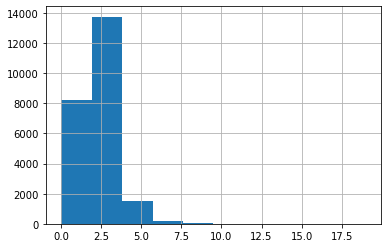

In [41]:
df.rooms.hist()

<AxesSubplot:>

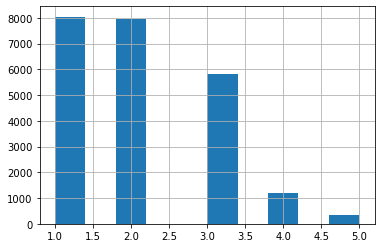

In [42]:
# предлождение объектов с количеством комнта до 6 комнат
df.query('0 < rooms < 6').rooms.hist(bins=10)

<AxesSubplot:>

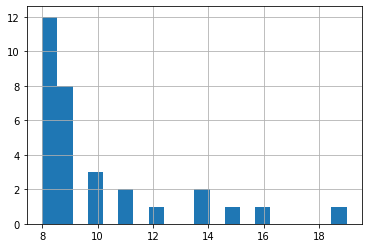

In [43]:
df.query('7 < rooms < 20').rooms.hist(bins=20)

Предаставлен один объект с комнатами в кол-ве 19

### Высота потолков

In [44]:
df.ceiling_height.describe()

count    23699.000000
mean         2.724358
std          0.988298
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

In [45]:
df.query('ceiling_height > 50')['ceiling_height'].count()

1

* Среднее - 2.72м
* Медиана - 2,65м
* Максимальное - 100м, что однозначно является ошибкой, если только человек не живет в Лахта центре, причем на ресепш, хотя кто его туда пропишет )

<AxesSubplot:>

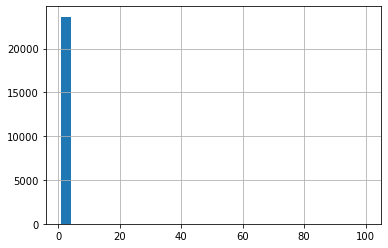

In [46]:
# общая гистограмма
df.ceiling_height.hist(bins=30)

<AxesSubplot:>

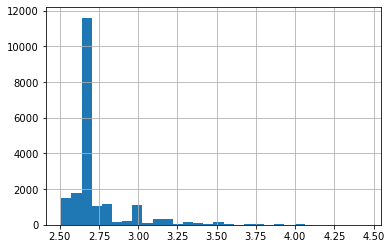

In [47]:
# высота потолков от 2,5м до 4,5м
df.query(' 2.5 < ceiling_height < 4.5')['ceiling_height'].hist(bins=30)

In [48]:
# Доля предложений с потолком выше 3,25м
len(df.query('3.25 < ceiling_height')) / len(df)

0.03236423477783873

Для потолков высотой от 2,5м до 4,5м распределение имеет обычную форму и стремится к Пуассоновскому

<AxesSubplot:>

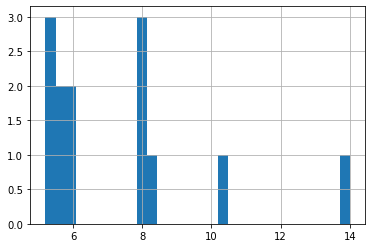

In [49]:
# высота потолков от 5м до 20м

df.query(' 5 < ceiling_height < 20')['ceiling_height'].hist(bins=30)

Для потолков от 5м до 20м имеются всплески, которые можно объяснить человеческим фактором, однако точно указать, какое значение хотел внести оператор, в данном случае невозможно.

<AxesSubplot:>

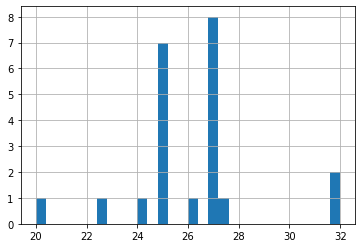

In [50]:
# высота потолков от 18м до 50м
df.query(' 18 < ceiling_height < 50')['ceiling_height'].hist(bins=30)

Для высоты от 20м до 50м наблюдаются значения в промежутке от 20м до 32м, что явно говорит о человеском факторе: оператор при внесении данных ошибся и пропустил запятую. Таким образом эти значение стоит разделить на 10, чтобы они были полезны и соответствовали действительнотси.

In [51]:
df.loc[(df['ceiling_height'] < 50) & (df['ceiling_height'] > 18), 'ceiling_height'] = \
    df.loc[(df['ceiling_height'] < 50) & (df['ceiling_height'] > 18), 'ceiling_height'] / 10

# проверим, остались ли ошибки в диапазоне от 18м до 50м
df.query(' 18 < ceiling_height < 50')['ceiling_height'].count()

0

In [52]:
# проверим, остались ли ошибки в диапазоне от 18м до 50м
df.query(' 18 < ceiling_height < 50')['ceiling_height'].count()

0

### Исследование длительности продажи

In [53]:
df.days_exposition.describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

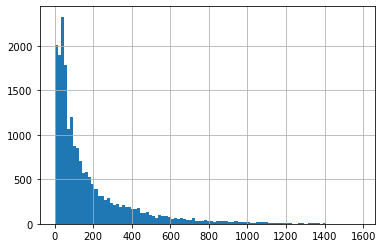

In [54]:
df.days_exposition.hist(bins=100)

Рассмотрим более подробно 4-й квартиль: (232 продаже и более) 

<AxesSubplot:>

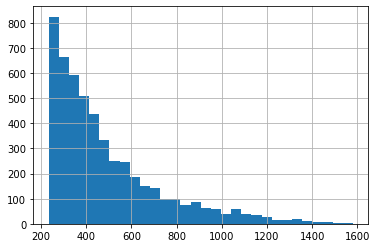

In [55]:
df.query(' 232 < days_exposition')['days_exposition'].hist(bins=30)

<AxesSubplot:>

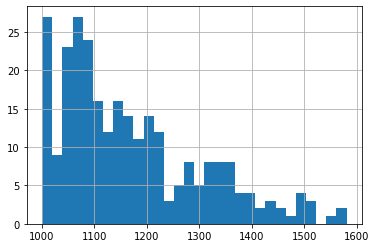

In [56]:
# рассмотрим "хвост"
df.query(' 1000 < days_exposition')['days_exposition'].hist(bins=30)

Время продажи квардир приближается к Пуассоновскому распределению и вопросов не вызывает

Сгруппируем данные по времени продажи квартир и сделаем вывод

In [57]:
labels = ['quckly', 'rather_quickly', 'average', 'rather_slowly', 'slowly']
df['a_sale_speed'] = pd.qcut(df.days_exposition , q=5, labels=labels)
df.a_sale_speed.unique()

[NaN, 'average', 'slowly', 'rather_quickly', 'rather_slowly', 'quckly']
Categories (5, object): ['quckly' < 'rather_quickly' < 'average' < 'rather_slowly' < 'slowly']

Методом ***describe()*** найдем параметры, соответствующие каждой из групп и объедим полученные значения в единую таблицу

In [58]:
quckly = df.loc[df['a_sale_speed'] == 'quckly']['days_exposition'].describe()
rather_quickly = df.loc[df['a_sale_speed'] == 'rather_quickly']['days_exposition'].describe()
average = df.loc[df['a_sale_speed'] == 'average']['days_exposition'].describe()
rather_slowly = df.loc[df['a_sale_speed'] == 'rather_slowly']['days_exposition'].describe()
slowly = df.loc[df['a_sale_speed'] == 'slowly']['days_exposition'].describe()

In [59]:
frames = [quckly, rather_quickly, average, rather_slowly, slowly]
df_sale_speed = pd.concat(frames,  axis=1)
df_sale_speed.columns = ['quckly', 'rather_quickly', 'average', 'rather_slowly', 'slowly']
df_sale_speed = df_sale_speed.transpose()
df_sale_speed

,count,mean,std,min,25%,50%,75%,max
quckly,4218.0,17.813419,9.675824,1.0,9.0,17.0,26.0,35.0
rather_quickly,4018.0,50.989547,8.737302,36.0,45.0,49.0,60.0,67.0
average,4102.0,98.283276,19.026700,68.0,83.0,96.0,114.0,135.0
rather_slowly,4078.0,198.003188,43.177040,136.0,161.0,191.0,232.0,287.0
slowly,4102.0,541.405412,241.146637,288.0,364.0,460.0,647.0,1580.0


Text(0, 0.5, 'days')

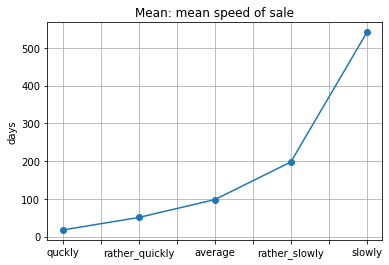

In [60]:
# Средняя скорость продажи
df_sale_speed['mean'].plot(style='o-', grid=True)
plt.title("Mean: mean speed of sale")
plt.ylabel("days")

Text(0, 0.5, 'days')

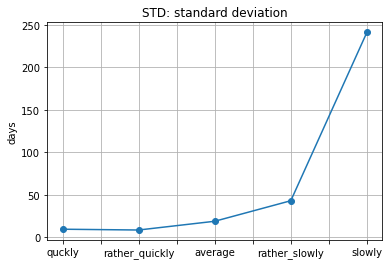

In [61]:
# Стандартное отклонение
df_sale_speed['std'].plot(style='o-',  grid=True)
plt.title("STD: standard deviation")
plt.ylabel("days")

Text(0, 0.5, 'days')

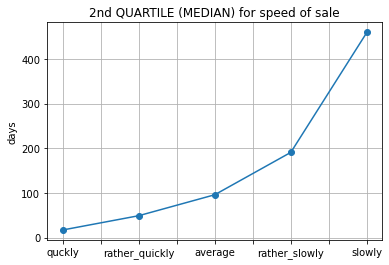

In [62]:
# Медиана
df_sale_speed['50%'].plot(style='o-',  grid=True)
plt.title("2nd QUARTILE (MEDIAN) for speed of sale")
plt.ylabel("days")

#### ***Вывод***
* Средняя площадь квартиры порядка 60кв.м.
* Цена в среднем составляет около 4,500,000р
* Дорогой сегмент начинает от 6,800,000р и достегает 400,000,000р
* В основном продают двух-  и трехкомнатные квартиры, однако есть предложения в 4, 5, 8 и более комнат
* Высота потолков стандартна и составляет порядка 2,7м. есть предложения с высотой потолков более 3,25м, которых около 3%


* В среднем квартира продается за порядка 3 месяца (98 дней) 
* Можно считать, что продажа осуществлена быстро, если квартира продана в среднем за 2 - 3 недели (вреднем 17 дней)
* Долго продающиеся квартиры ожидают сделки порядка 1,5 лет (в среднем 541 день)

### Удаление редких и выбивающихся значений

Была обнаружены следующие предложения с выбивающимися и нелогичными параметрами

In [63]:
df.loc[(df['ceiling_height'] == df.ceiling_height.max()) \
       | (df['last_price'] == df.last_price.max())       \
       | (df['rooms'] == df.rooms.max())                 \
       | (df['total_area'] == df.total_area.max()) ]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,a_squere_meter_price,date,a_day,a_month,a_year,a_floor_cat,a_living_to_total_area,a_kitchen_to_total_area,a_sale_speed
12971,19,763000.0,400,2017-09-30T00:00:00,7,2.65,10,250.0,10,False,...,33.0,1.907500e+06,2017-09-30,5,9,2017,last,0.625000,0.050000,quckly
14498,6,32250.0,374,2018-06-09T00:00:00,19,2.65,5,264.5,2,False,...,114.0,8.622995e+04,2018-06-09,5,6,2018,other,0.707219,0.073797,average
19540,8,420000.0,900,2017-12-06T00:00:00,12,2.80,25,409.7,25,False,...,106.0,4.666667e+05,2017-12-06,2,12,2017,last,0.455222,0.124444,average
22869,0,15000.0,25,2018-07-25T00:00:00,1,100.00,5,14.0,5,True,...,19.0,6.000000e+05,2018-07-25,2,7,2018,last,0.560000,0.440000,quckly


In [64]:
print('для которых:')
print('Высота потолков: ', df.ceiling_height.max())
print('Цена: ', df.last_price.max())  
print('Количество комнат: ', df.rooms.max())
print('Общая площадь: ', df.total_area.max())

для которых:
Высота потолков:  100.0
Цена:  763000.0
Количество комнат:  19
Общая площадь:  900


Данные параметра можно объяснить человеческим фактором, но направление, в котором можно исправить данные значения, определить сложно. В связи с этим информацию о даннах предложениях лучше не использовать в дальнейшем анализе

In [65]:
df_len_initial = len(df)
df = df.loc[(df['ceiling_height'] != df.ceiling_height.max()) \
       & (df['last_price'] != df.last_price.max())            \
       & (df['rooms'] != df.rooms.max())                      \
       & (df['total_area'] != df.total_area.max()) ]
df_len_final = len(df)
print(f'Удалены {df_len_initial - df_len_final} строки')

Удалены 4 строки


### Корреляция цены квартиры

#### Для всей выборки

In [66]:
print(f'Корреляция цены квартиры с площадью: {df.last_price.corr(df.total_area)}')
print(f'Корреляция цены квартиры с числом комнат: {df.last_price.corr(df.rooms)}')
print(f'Корреляция цены квартиры с удаленностью от центар: {df.last_price.corr(df.cityCenters_nearest)}')
print()
print('Корреляция цены квартиры от категории этажа:\nfirst - первый этаж\nother - другой этаж\nlast - последний этаж')
print()
for value in df.a_floor_cat.unique():
    print(value, end='\t')
    print(df.query('a_floor_cat == @value')['floor'].corr(df.query('a_floor_cat == @value')['last_price']))

Корреляция цены квартиры с площадью: 0.6954754600639843
Корреляция цены квартиры с числом комнат: 0.3920717108671085
Корреляция цены квартиры с удаленностью от центар: -0.23654535155967954

Корреляция цены квартиры от категории этажа:
first - первый этаж
other - другой этаж
last - последний этаж

other	-0.014350321528788925
first	0.05282084818974536
last	0.02127011877187642


In [67]:
# print(f'Зависимость цены квартиры от дня недели: {df.last_price.corr(df.a_day)}')
# print(f'Зависимость цены квартиры от месяца: {df.last_price.corr(df.a_month)}')
# print(f'Зависимость цены квартиры от года: {df.last_price.corr(df.a_year)}')


Рассмотрим корреляцию в общих данных следующих параметров между собой:
* количество комнта
* этаж
* удаленность от центра
* дата подачи объявления

Параметр: rooms,
корелляция с ценой: 0.04474281818746408

Параметр: floor,
корелляция с ценой: 0.13156173834189774

Параметр: cityCenters_nearest,
корелляция с ценой: -0.32772704709526834

Параметр: date_num,
корелляция с ценой: 0.00999952971015093



<AxesSubplot:>

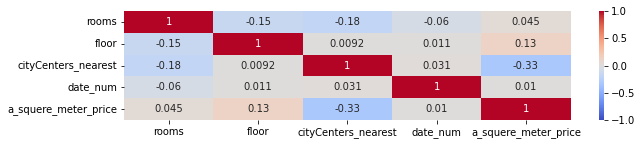

In [68]:
df['date_num'] = pd.to_numeric(df['date'], errors='coerce')
df_whole = df[['rooms', 'floor', 'cityCenters_nearest', 'date_num', 'a_squere_meter_price']]
param = ['rooms', 'floor', 'cityCenters_nearest', 'date_num']
for item in param:
    print(f'Параметр: {item},\nкорелляция с ценой: {df_whole.a_squere_meter_price.corr(df_whole[item])}')
    print()

fig, ax = plt.subplots(figsize=(10,2))
sns.heatmap(df_whole.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', ax = ax)

<span style='background:yellow'>Для отображения возможной имеющейся зависимости таких параметров, как количество комнат, этаж, ,удаленность от центра и дата подачи объявления будем использовать диаграмму матрицы рассеивания
</span>

array([[<AxesSubplot:xlabel='rooms', ylabel='rooms'>,
        <AxesSubplot:xlabel='floor', ylabel='rooms'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='rooms'>,
        <AxesSubplot:xlabel='date_num', ylabel='rooms'>],
       [<AxesSubplot:xlabel='rooms', ylabel='floor'>,
        <AxesSubplot:xlabel='floor', ylabel='floor'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='floor'>,
        <AxesSubplot:xlabel='date_num', ylabel='floor'>],
       [<AxesSubplot:xlabel='rooms', ylabel='cityCenters_nearest'>,
        <AxesSubplot:xlabel='floor', ylabel='cityCenters_nearest'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='cityCenters_nearest'>,
        <AxesSubplot:xlabel='date_num', ylabel='cityCenters_nearest'>],
       [<AxesSubplot:xlabel='rooms', ylabel='date_num'>,
        <AxesSubplot:xlabel='floor', ylabel='date_num'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='date_num'>,
        <AxesSubplot:xlabel='date_num', ylabel='date_num'

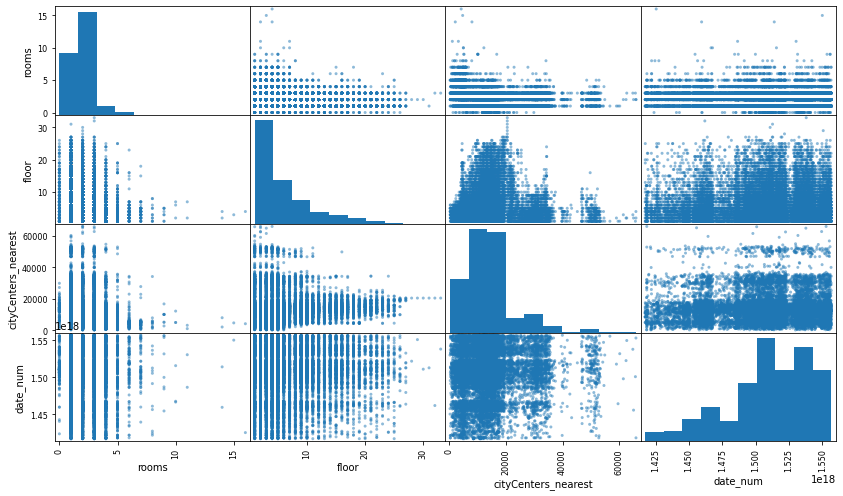

In [69]:
df_scat = df[['rooms', 'floor', 'cityCenters_nearest', 'date_num']]
pd.plotting.scatter_matrix(df_scat, figsize=(14, 8))

<span style='background:yellow'>Можно сделать вывод об отчетливом отображении зависимости количества этажности зданий от удаленности от центра города, что логично, так как высотная застройка в центре города в основном запрещена из-за исторической ценности
</span>




<span style='background:yellow'>
Также видно увеличение количества комнат для объектов в центральной части города
</span>

<span style='background:yellow'>Расчитаем и отобразим среднюю цену объекта продажи для таких параметров, как день, месяц и год</span>

In [70]:
df_pivot_day = pd.pivot_table(df, index='a_day', values='last_price')
df_pivot_month = pd.pivot_table(df, index='a_month', values='last_price')
df_pivot_year = pd.pivot_table(df, index='a_year', values='last_price')

max last_price    6708.663232
dtype: float64
min last_price    6246.180298
dtype: float64
last_price    6.893817
dtype: float64


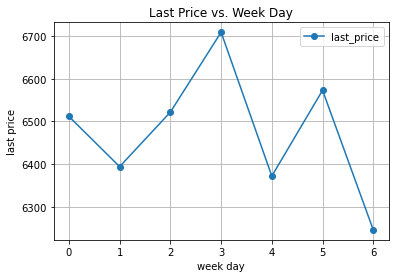

In [71]:
df_pivot_day.plot(style='o-',  grid=True)
plt.title("Last Price vs. Week Day")
plt.ylabel("last price")
plt.xlabel("week day")
maximum = df_pivot_day.max()
print(f'max {maximum}')
minimum = df_pivot_day.min()
print(f'min {minimum}')
print((maximum - minimum) / maximum * 100)

max last_price    6759.909318
dtype: float64
min last_price    6235.013094
dtype: float64
last_price    7.764841
dtype: float64


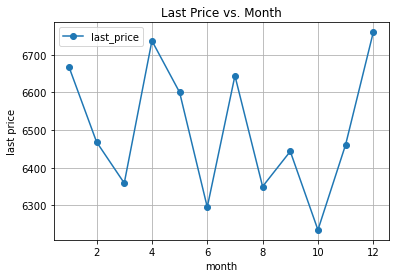

In [72]:
df_pivot_month.plot(style='o-',  grid=True)
plt.title("Last Price vs. Month")
plt.ylabel("last price")
plt.xlabel("month")
maximum = df_pivot_month.max()
print(f'max {maximum}')
minimum = df_pivot_month.min()
print(f'min {minimum}')
print((maximum - minimum) / maximum * 100)

max last_price    12087.135942
dtype: float64
min last_price    5946.816139
dtype: float64
last_price    50.800453
dtype: float64


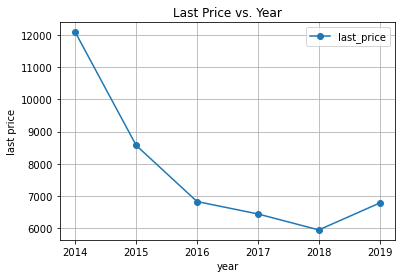

In [73]:
df_pivot_year.plot(style='o-',  grid=True)
plt.title("Last Price vs. Year")
plt.ylabel("last price")
plt.xlabel("year")
maximum = df_pivot_year.max()
print(f'max {maximum}')
minimum = df_pivot_year.min()
print(f'min {minimum}')
print((maximum - minimum) / maximum * 100)

<span style='background:yellow'>
В период с 2014 по 2019гг. включительно замечены следующие особенности в параметре "Цена объекта" ("last price")
</span>

<span style='background:yellow'>* **День недели**: максимальная средняя цена выставляемого на продажу объекта соответствует четвергу, минимальная - воскресенью, и колеблется в пределах от 6,246,000р до 6709,000р., что показывает разрыв в 6,89% от максимального значения</span>

<span style='background:yellow'>* **Месяц**: максимальная средняя цена выставляемого на продажу объекта соответствует декабрю, минимальная - октябрю, и колеблется в пределах от 6,235,000р до 6,760,000р., что показывает разрыв в 7,76% от максимального значения</span>

<span style='background:yellow'>* **Год**: максимальная средняя цена выставляемого на продажу объекта соответствует 2014г., минимальная - 2018г., и колеблется в пределах от 5,947,000р до 12,087,000р., что показывает разрыв в почти 51% от максимального значения</span>

#### Для центра
Топ 10 насленных пунктов и городов по кол-ву поданых объявлений

In [74]:
top10_offer_locations = df['locality_name'].value_counts().sort_values(ascending=False).head(10).index
top10_offer_locations

Index(['Санкт-Петербург', 'посёлок Мурино', 'посёлок Шушары', 'Всеволожск',
       'Пушкин', 'Колпино', 'посёлок Парголово', 'Гатчина', 'деревня Кудрово',
       'Выборг'],
      dtype='object')

In [75]:
top10_square_meter = df.query('locality_name in @top10_offer_locations')                 \
    .pivot_table(index='locality_name', values='a_squere_meter_price', aggfunc='mean')   \
    .sort_values('a_squere_meter_price',ascending=False).reset_index()
top10_square_meter.a_squere_meter_price = top10_square_meter.a_squere_meter_price.astype('int')
top10_square_meter

,locality_name,a_squere_meter_price
0,Санкт-Петербург,115182
1,Пушкин,103611
2,деревня Кудрово,93002
3,посёлок Парголово,90675
4,посёлок Мурино,86379
5,посёлок Шушары,79068
6,Колпино,75735
7,Гатчина,69045
8,Всеволожск,68985
9,Выборг,58296


In [80]:
#Максиммальная цена кв.метра
temp1 = top10_square_meter.query('a_squere_meter_price == a_squere_meter_price.max()')['locality_name']
print(f'Максимальная цена в городе: ', temp1[temp1.index.max()])

#Минимальная цена кв.метра
temp2 = top10_square_meter.query('a_squere_meter_price == a_squere_meter_price.min()')['locality_name']
print(f'Минимальная цена в городе: ', temp2[temp2.index.max()])

Максимальная цена в городе:  Санкт-Петербург
Минимальная цена в городе:  Выборг


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Санкт-Петербург'),
  Text(1, 0, 'Пушкин'),
  Text(2, 0, 'деревня Кудрово'),
  Text(3, 0, 'посёлок Парголово'),
  Text(4, 0, 'посёлок Мурино'),
  Text(5, 0, 'посёлок Шушары'),
  Text(6, 0, 'Колпино'),
  Text(7, 0, 'Гатчина'),
  Text(8, 0, 'Всеволожск'),
  Text(9, 0, 'Выборг')])

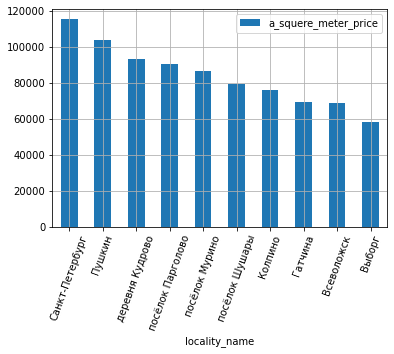

In [81]:
top10_square_meter.plot(x='locality_name', y='a_squere_meter_price', grid = True, kind = 'bar')
plt.xticks(rotation=70)

,a_squere_meter_price
a_dist,
0,187717.073514
1,166806.271576
2,147017.069402
3,126498.797347
4,137582.002379


<AxesSubplot:xlabel='a_dist'>

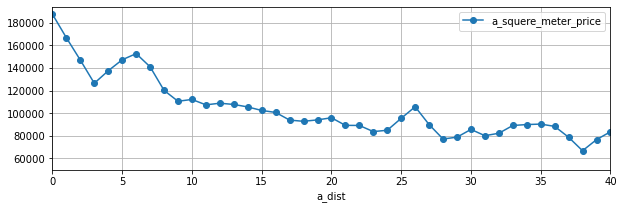

In [82]:
df['a_dist'] = df.cityCenters_nearest / 1000                  # по условию задачи делим перевод в км
df_dist = df[['a_dist','a_squere_meter_price']]               # отдельный фрейм для расчета
df_dist = df_dist.dropna()                                    # удаление пропусков
df_dist.a_dist = df_dist.a_dist.astype('int')                 # перевод в натуральные числа
df_dist_price = df_dist.pivot_table(index='a_dist', values='a_squere_meter_price')
display(df_dist_price.head())
df_dist_price.plot(y='a_squere_meter_price', style='o-', xlim=(0, 40), grid=True, figsize=(10, 3))

Можно сделать вывод, что центральная зона СПб. заканчивается при удалении от центра на расстояние более 8км

In [83]:
# # описание параметров: общая площадь, средняя цена за м.кв, кол-во комнат, высота потолков
# df_center = df.loc[df['a_dist'].notna()]
# df_center = df_center.query('a_dist <= 8')

# params = ['total_area', 'a_squere_meter_price', 'rooms', 'ceiling_height']
# for item in params:
#     print(f'Параметр: {item}')
#     print(df_center[item].describe())
#     print()    

In [84]:
# описание параметров: общая площадь, средняя цена за м.кв, кол-во комнат, высота потолков
df_center = df.loc[df['a_dist'].notna()]
df_center = df_center.query('a_dist <= 8')

params = ['total_area', 'a_squere_meter_price', 'rooms', 'ceiling_height']
for item in params:
    print(f'Параметр: {item}')
    print(df_center[item].describe())
    print()    

Параметр: total_area
count    3725.000000
mean       91.705235
std        58.609382
min        12.000000
25%        56.000000
50%        77.000000
75%       108.000000
max       631.000000
Name: total_area, dtype: float64

Параметр: a_squere_meter_price
count    3.725000e+03
mean     1.441586e+05
std      8.702427e+04
min      1.538462e+04
25%      1.000000e+05
50%      1.236364e+05
75%      1.553304e+05
max      1.736842e+06
Name: a_squere_meter_price, dtype: float64

Параметр: rooms
count    3725.000000
mean        2.805906
std         1.420718
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        16.000000
Name: rooms, dtype: float64

Параметр: ceiling_height
count    3725.000000
mean        2.929289
std         0.370142
min         2.000000
25%         2.650000
50%         2.800000
75%         3.100000
max         6.000000
Name: ceiling_height, dtype: float64



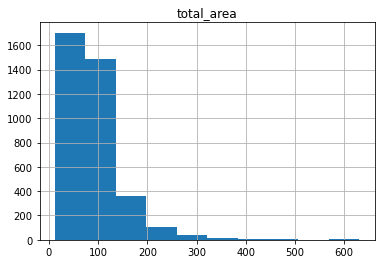

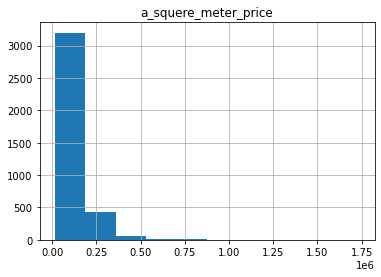

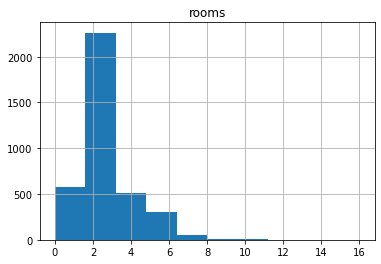

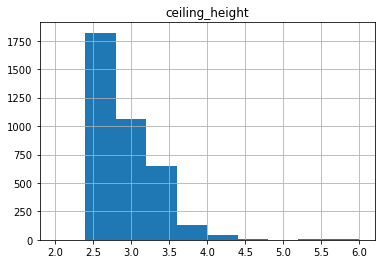

In [85]:
# описание параметров: общая площадь, средняя цена за м.кв, кол-во комнат, высота потолков
df_center = df.loc[df['a_dist'].notna()]
df_center = df_center.query('a_dist <= 8')

params = ['total_area', 'a_squere_meter_price', 'rooms', 'ceiling_height']
for item in params:
    df_center.hist(item)
    print()   

* Общая площадь:

<span style='background:yellow'>Представлено 3725 объектов со средней площадью 91кв.м. и максимальной площадью 631кв.м.
</span>

* Цена кв.м.

<span style='background:yellow'>Средняя цена кв.м. составляет около 144,000р. и достигает в максимуме 1.737.000р.
</span>

* Высота потолков

<span style='background:yellow'>Медианная и средняя высота потолков равны стандарту: 2,80 - 2,92м. Присутствуют объекты с высотой потолков более 5м
</span>

Построим корреляционную матрицу для нескольких параметров:

In [86]:
# df_center_param = df_center[['rooms', 'floor', 'cityCenters_nearest', 'date_num', 'a_squere_meter_price', 'total_area', 'last_price']]
# param = ['rooms', 'floor', 'cityCenters_nearest', 'date_num', 'a_squere_meter_price', 'total_area', 'last_price']
# for item in param:
#     print(f'Параметр: {item},\nкорелляция с ценой: {df_center_param.last_price.corr(df_center_param[item])}')
#     print()

# fig, ax = plt.subplots(figsize=(10,2))
# sns.heatmap(df_center_param.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', ax = ax)

Параметр: rooms,
корелляция с ценой: 0.3470992740325556

Параметр: floor,
корелляция с ценой: 0.09894269071991252

Параметр: total_area,
корелляция с ценой: 0.6694486901543271

Параметр: last_price,
корелляция с ценой: 1.0



<AxesSubplot:>

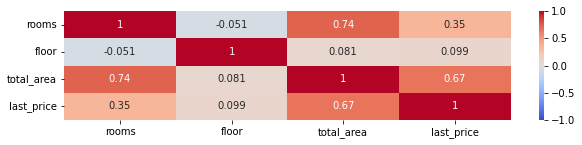

In [87]:
df_center_param = df_center[['rooms', 'floor', 'total_area', 'last_price']]
param = ['rooms', 'floor', 'total_area', 'last_price']
for item in param:
    print(f'Параметр: {item},\nкорелляция с ценой: {df_center_param.last_price.corr(df_center_param[item])}')
    print()

fig, ax = plt.subplots(figsize=(10,2))
sns.heatmap(df_center_param.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', ax = ax)

<span style='background:yellow'>Аналогично общему датасету представим диаграму матрицы рассеивания для заданных параметров относительно центральной зоны СПб<span>

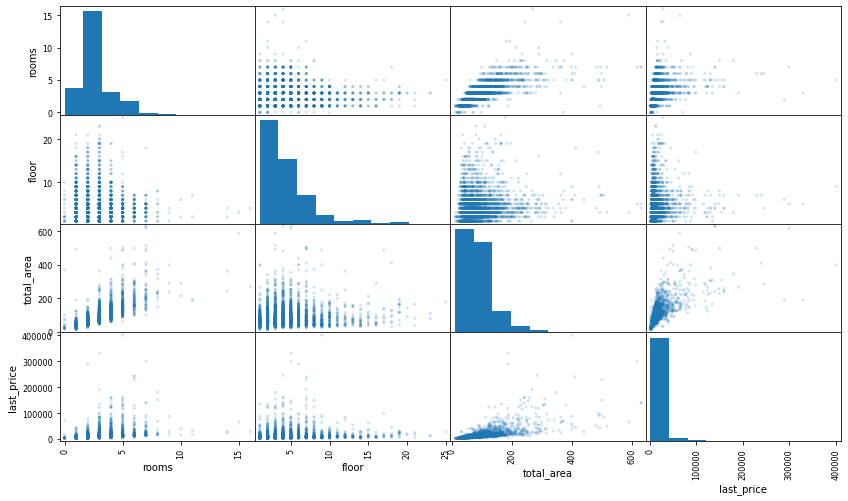

In [89]:
pd.plotting.scatter_matrix(df_center_param, figsize=(14, 8), alpha=0.2)
plt.show()

<span style='background:yellow'>
Исходя из графического представления и корреляционных коэффициентов видна зависимость цены объекта от общей площади обхекта и количества комнат
</span>

Сравним цену объекта и за кв.м. в центре и за центром СПб.

In [90]:
square_meter_incenter = df.query('a_dist < 8')['a_squere_meter_price'].mean()
square_meter_outofcenter = df.query('a_dist > 8')['a_squere_meter_price'].mean()
price_incenter = df_center.query('a_dist <=8')['last_price'].mean()
price_outofcenter = df.query('a_dist > 8')['last_price'].mean()
print(f'Цена за кв.м. в центре: {square_meter_incenter}')
print(f'Цена за кв.м. вне центра: {square_meter_outofcenter}')
print(f'Цена за объект в центре: {price_incenter}')
print(f'Цена за объект вне центра: {price_outofcenter}')
print()
# Соотношение цен объектов в разныех зонах:
print(f'Цена за кв.м. больше в центра в {square_meter_incenter / square_meter_outofcenter} раз')
print(f'Цена за объект больше в центра в {price_incenter / price_outofcenter} раз')

Цена за кв.м. в центре: 144158.62834244897
Цена за кв.м. вне центра: 102421.53787281737
Цена за объект в центре: 14393.685984161075
Цена за объект вне центра: 5731.792629921805

Цена за кв.м. больше в центра в 1.4075030636764985 раз
Цена за объект больше в центра в 2.5112014536292526 раз


#### ***Вывод***

***Корреляция средней цены для всего набора данных с:***
* День недели, месяц и год -  не обнаружена
* Кол-во комнат, этаж, расстояние до центра, дата – не обнаружена
* Этаж незначительно влияет на цену квадратного метра, коэфф-т составляет 0,13



***В центральную зону СПб. входят объекты на расстоянии порядка 8км от города.***

Корреляция средней цены для центра города с:
* Цена квадратного метра мало коррелирует с количеством комнат, этажом и расстоянием до центра
* Максимальный коэфф-т корреляции имеют общая площадь (0,67) и средняя цена за 1кв.м (0,78)
* Цена за кв.м. в центральной зоне больше на 40%
* Цена объекта в центральной зоне больше в 2,5 раза


***Топ 10 по кол-ву предложений:***
* Санкт-Петербург
* Пушкин
* деревня Кудрово
* посёлок Парголово
* посёлок Мурино
* посёлок Шушары
* Колпино
* Гатчина
* Всеволожск
* Выборг

## Общий вывод

* данные представлены в файле из 23699 строк и 22 показателей
* явные дубликаты отсутствуют
* в 13 показателях имеются пропуски
* данные представлены для СПб. и пригородов за период с 2014 по 2019 годы

***Заполнены пропуски в таких показателях, как:***
* Количество балконов
* Высота потолков
* Первый этаж
* Статус апартаментов
* Площадь кухни
* Жилая площадь
* Число парков в радиусе 3 км
* Расстояние до ближайшего парка (м)
* Число водоёмов в радиусе 3 км
* Расстояние до ближайшего водоёма (м)

***Добавлены значения:***
* Цена квадратного метра
* День недели, месяц и год публикации объявления

***Этажность:***
* Проведена группировка этажей квартир по этажности: первый этаж, последний этаж, другой
* 3000 квартир на первом этаже
* 3336 квартир на последнем этаже
* 17363 квартиры сгруппированы по этажности в категорию «другие»

***Площадь***
* Соотношение жилой и общей площади составляет в медиане порядка 50%
* Соотношение площади кухни к общей площади составляет в медиане порядка 18%

***Параметры квартир***
* Средняя площадь квартиры порядка 60кв.м.
* Цена в среднем составляет около 4,500,000р
* Дорогой сегмент начинает от 6,800,000р и достегает 400,000,000р
* В основном продают двух-  и трехкомнатные квартиры, однако есть предложения в 4, 5, 8 и более комнат
* Высота потолков стандартна и составляет порядка 2,7м. есть предложения с высотой потолков более 3,25м, которых около 3%

***Скорость продажи квартир***
* В среднем квартира продается за порядка 3 месяца (98 дней) 
* Можно считать, что продажа осуществлена быстро, если квартира продана в среднем за 2 - 3 недели (вреднем 17 дней)
* Долго продающиеся квартиры ожидают сделки порядка 1,5 лет (в среднем 541 день)

~***Корреляция средней цены для всего набора данных с:***~
~* День недели, месяц и год -  не обнаружена~
~* Кол-во комнат, этаж, расстояние до центра, дата – не обнаружена~
~* Этаж незначительно влияет на цену квадратного метра, коэфф-т составляет 0,13~



***Средняя цена объекта относительно дня недели, месяца и года продажи:***


<span style='background:yellow'>
***В период с 2014 по 2019гг. включительно замечены следующие особенности в параметре "Цена объекта" ("last price")***
</span>

<span style='background:yellow'>* **День недели**: максимальная средняя цена выставляемого на продажу объекта соответствует четвергу, минимальная - воскресенью, и колеблется в пределах от 6,246,000р до 6709,000р., что показывает разрыв в 6,89% от максимального значения</span>

<span style='background:yellow'>* **Месяц**: максимальная средняя цена выставляемого на продажу объекта соответствует декабрю, минимальная - октябрю, и колеблется в пределах от 6,235,000р до 6,760,000р., что показывает разрыв в 7,76% от максимального значения</span>

<span style='background:yellow'>* **Год**: максимальная средняя цена выставляемого на продажу объекта соответствует 2014г., минимальная - 2018г., и колеблется в пределах от 5,947,000р до 12,087,000р., что показывает разрыв в почти 51% от максимального значения</span>


***В центральную зону СПб. входят объекты на расстоянии порядка 8км от города.***

Корреляция средней цены для центра города с:
* Цена квадратного метра мало коррелирует с количеством комнат, этажом и расстоянием до центра
* Максимальный коэфф-т корреляции имеют общая площадь (0,67) и средняя цена за 1кв.м (0,78)
* Цена за кв.м. в центральной зоне больше на 40%
* Цена объекта в центральной зоне больше в 2,5 раза

***Топ 10 по кол-ву предложений:***
* Санкт-Петербург
* Пушкин
* деревня Кудрово
* посёлок Парголово
* посёлок Мурино
* посёлок Шушары
* Колпино
* Гатчина
* Всеволожск
* Выборг